In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import itertools
import sys
sys.path.append('..')
from security_game.target import Target
from security_game.green_security_game import GreenSecurityGame
from security_game.infra_security_game import InfraSecurityGame

from solvers.mip import mip
from solvers.nash import nash
from solvers.double_oracle import double_oracle
from solvers.double_oracle_sf import double_oracle_sf
from solvers.no_regret import regret_matching
from solvers.simple_sse_lp import solve_sse_lp
from solvers.nfg_sse_lp import solve_general_sum_normal_form
import time
from matplotlib import pyplot as plt
from collections import defaultdict, Counter

# GSG

In [32]:
df = pd.read_csv("lobeke.csv")
df.dropna(inplace=True)

# Lobeke National Park Bounding Box
# lat_min, lon_min = 2.05522, 15.8790
# lat_max, lon_max = 2.2837, 16.2038

lat_min, lon_min = 2.0530, 15.8790
lat_max, lon_max = 2.2837, 16.2038

coordinate_rectangle = [lat_min, lat_max, lon_min, lon_max]


boulou_camp = (2.2,15.9)
# lobeke_camp = (2.25,15.75)
kabo_djembe = (2.0532352380408088, 16.085709866529694)
bomassa = (2.2037280296158355, 16.187056364164913)
inner_post = (2.2,15.98)
sangha_river = [(2.2837, 16.16283352464626),(2.053, 16.066212728001727)]

## Simple SSE LP

In [33]:
schedule_form_kwargs = {
    "schedule_form": True,
    "simple": True,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5,
}

general_sum_kwargs = {
    "general_sum": True,
    "attacker_animal_value":  2350, 
    "defender_animal_value": 22966, 
    "defender_step_cost": 0, 
}


num_timesteps_li = []
num_defenders_li = []
num_clusters_li = []
dims_li = []
dts = []
supports=[]

dus = []
runtimes = []
i=0

for num_timesteps in [7,8,9,10,11]:
    for num_defenders in [1,2,3]:
        for num_clusters in [7,8,9,10,11,12]:
            for dims in [7,8,9,10]:
                for dt in [1,2]:
                    gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims, escape_line_points=sangha_river)
                    gsg.generate(num_attackers=1, 
                                 num_defenders=num_defenders, 
                                 home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], 
                                 num_timesteps=num_timesteps, 
                                 generate_utility_matrix=False, 
                                 defense_time_threshold=dt, 
                                 force_return=True, 
                                 **schedule_form_kwargs,
                                 **general_sum_kwargs)
                    start = time.time()
                    _, coverage, du = solve_sse_lp(gsg.schedule_form_dict)
                    end=time.time()
                    num_timesteps_li.append(num_timesteps)
                    num_defenders_li.append(num_defenders)
                    num_clusters_li.append(num_clusters)
                    dims_li.append(dims)
                    dts.append(dt)
                    
                    support = sum([1 for t,p in coverage.items() if p!=0])
                    dus.append(du)
                    runtimes.append(end-start)
                    supports.append(support)
                    print(f"{i}/719: timesteps:{num_timesteps}, num_defenders:{num_defenders}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, support:{support}, du:{du}")
                    i+=1

0/719: timesteps:7, num_defenders:1, num_clusters:7, dims:7, dt:1, support:3, du:-0.5109827594175502
1/719: timesteps:7, num_defenders:1, num_clusters:7, dims:7, dt:2, support:3, du:-0.5109827594175502
2/719: timesteps:7, num_defenders:1, num_clusters:7, dims:8, dt:1, support:4, du:-0.420216155702044
3/719: timesteps:7, num_defenders:1, num_clusters:7, dims:8, dt:2, support:0, du:-0.7872340425531915
4/719: timesteps:7, num_defenders:1, num_clusters:7, dims:9, dt:1, support:3, du:-0.5433835292520426
5/719: timesteps:7, num_defenders:1, num_clusters:7, dims:9, dt:2, support:0, du:-0.7872340425531915
6/719: timesteps:7, num_defenders:1, num_clusters:7, dims:10, dt:1, support:4, du:-0.43289105864648164
7/719: timesteps:7, num_defenders:1, num_clusters:7, dims:10, dt:2, support:0, du:-0.7872340425531915
8/719: timesteps:7, num_defenders:1, num_clusters:8, dims:7, dt:1, support:3, du:-0.5062107321301194
9/719: timesteps:7, num_defenders:1, num_clusters:8, dims:7, dt:2, support:3, du:-0.50621

In [34]:
df = pd.DataFrame()
df["num_timesteps"] = num_timesteps_li
df["num_defenders"] = num_defenders_li
df["num_clusters"] = num_clusters_li
df["dims"] = dims_li
df["defense_time_threshold"] = dts
df["defender_utility"] = dus
df["support"] = supports
df["runtime"] = runtimes
df

,num_timesteps,num_defenders,num_clusters,dims,defense_time_threshold,defender_utility,support,runtime
0,7,1,7,7,1,-0.510983,3,0.044647
1,7,1,7,7,2,-0.510983,3,0.007505
2,7,1,7,8,1,-0.420216,4,0.010371
3,7,1,7,8,2,-0.787234,0,0.006608
4,7,1,7,9,1,-0.543384,3,0.007524
...,...,...,...,...,...,...,...,...
715,11,3,12,8,2,-0.216784,6,0.018672
716,11,3,12,9,1,-0.224794,6,0.019016
717,11,3,12,9,2,-0.224794,6,0.019058
718,11,3,12,10,1,-0.216778,6,0.019136


In [35]:
df.to_csv("GSG_SIMPLE_SSE_v2.csv")

## General SSE LP

In [3]:
schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 5,
    "defender_penalty_factor": 5
}

general_sum_kwargs = {
    "general_sum": True,
    "attacker_animal_value":  2350, 
    "defender_animal_value": 22966, 
    "defender_step_cost": 1.17, 
}


num_timesteps_li = []
num_defenders_li = []
num_clusters_li = []
dims_li = []
dts = []
supports=[]

dus = []
runtimes = []
i=0

for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for num_clusters in [7,8,9,10]: # no 11 or 12 bc too large to solve at high timesteps
            for dims in [7,8,9,10]:
                for dt in [1,2]:
                    gsg = GreenSecurityGame(df, coordinate_rectangle, "centroid", num_clusters=num_clusters, num_rows=dims, num_columns=dims, escape_line_points=sangha_river)
                    gsg.generate(num_attackers=1, 
                                 num_defenders=num_defenders, 
                                 home_base_assignments=[(kabo_djembe, bomassa, inner_post) for i in range(num_defenders)], 
                                 num_timesteps=num_timesteps, 
                                 generate_utility_matrix=True, 
                                 defense_time_threshold=dt, 
                                 force_return=True,
                                 **schedule_form_kwargs,
                                 **general_sum_kwargs)
                    
                    start = time.time()
                    _, coverage, du = solve_general_sum_normal_form(gsg.schedule_form_dict["defender_utility_matrix"], gsg.schedule_form_dict["attacker_utility_matrix"])
                    end=time.time()
                    num_timesteps_li.append(num_timesteps)
                    num_defenders_li.append(num_defenders)
                    num_clusters_li.append(num_clusters)
                    dims_li.append(dims)
                    dts.append(dt)
                    
                    support = sum([1 for t,p in coverage.items() if p!=0])
                    dus.append(du)
                    runtimes.append(end-start)
                    supports.append(support)
                    print(f"{i}/383: timesteps:{num_timesteps}, num_defenders:{num_defenders}, num_clusters:{num_clusters}, dims:{dims}, dt:{dt}, support:{support}, du:{du}")
                    i+=1

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2455389
Academic license 2455389 - for non-commercial use only - registered to jc___@columbia.edu
0/383: timesteps:7, num_defenders:1, num_clusters:7, dims:7, dt:1, support:4, du:-0.40524711019143855
1/383: timesteps:7, num_defenders:1, num_clusters:7, dims:7, dt:2, support:4, du:-0.41782199603182346
2/383: timesteps:7, num_defenders:1, num_clusters:7, dims:8, dt:1, support:5, du:-0.3684854638105539
3/383: timesteps:7, num_defenders:1, num_clusters:7, dims:8, dt:2, support:1, du:-0.7865803625348039
4/383: timesteps:7, num_defenders:1, num_clusters:7, dims:9, dt:1, support:5, du:-0.3538746887050234
5/383: timesteps:7, num_defenders:1, num_clusters:7, dims:9, dt:2, support:1, du:-0.7870220186613368
6/383: timesteps:7, num_defenders:1, num_clusters:7, dims:10, dt:1, support:5, du:-0.36295935047814964
7/383: timesteps:7, num_defenders:1, num_clusters:7, dims:10, dt:2, support:1, du:-0.7870432069638549
8/383:

In [4]:
df = pd.DataFrame()
df["num_timesteps"] = num_timesteps_li
df["num_defenders"] = num_defenders_li
df["num_clusters"] = num_clusters_li
df["dims"] = dims_li
df["defense_time_threshold"] = dts
df["defender_utility"] = dus
df["support"] = supports
df["runtime"] = runtimes
df

,num_timesteps,num_defenders,num_clusters,dims,defense_time_threshold,defender_utility,support,runtime
0,7,1,7,10,1,-0.405247,4,0.008297
1,7,1,7,10,2,-0.417822,4,0.007579
2,7,1,7,10,1,-0.368485,5,0.011038
3,7,1,7,10,2,-0.786580,1,0.006007
4,7,1,7,10,1,-0.353875,5,0.010082
...,...,...,...,...,...,...,...,...
379,10,3,10,10,2,-0.171460,8,3.205177
380,10,3,10,10,1,-0.140295,9,4.725207
381,10,3,10,10,2,-0.199029,9,1.713607
382,10,3,10,10,1,-0.144598,9,4.842717


In [5]:
df.to_csv("GSG_NFG_SSE_v2.csv")

# ISG

In [2]:
gdf = gpd.read_file("chinatown_infra.geojson")

# Step 1: Handle relevant columns
infra_columns = [
    "id", "name", "power", "man_made", "amenity",
    "generator:method", "generator:source", "geometry"
]
available_columns = [col for col in infra_columns if col in gdf.columns]
gdf = gdf[available_columns].copy()

# Step 2: Extract generator type if present
gdf["generator_type"] = gdf.get("generator:method")
if "generator_type" not in gdf.columns or gdf["generator_type"].isnull().all():
    gdf["generator_type"] = gdf.get("generator:source")

# Step 3: Construct unified 'type' column
gdf["type"] = gdf.get("power")
if "amenity" in gdf.columns:
    gdf["type"] = gdf["type"].combine_first(gdf["amenity"])
if "man_made" in gdf.columns:
    gdf["type"] = gdf["type"].combine_first(gdf["man_made"])

# Step 4: Refine generator classification (solar vs. other)
gdf.loc[(gdf["type"] == "generator") & (gdf["generator_type"] == "photovoltaic"), "type"] = "solar_generator"
gdf.loc[(gdf["type"] == "generator") & (gdf["generator_type"] == "solar"), "type"] = "solar_generator"

# Step 5: Drop raw columns now that 'type' is finalized
df_simple = gdf[["id", "name", "type", "geometry"]].copy()

# Step 6: Separate nodes and ways
df_nodes = df_simple[df_simple["id"].str.contains("node")].copy()
df_nodes["x"] = df_nodes.geometry.x
df_nodes["y"] = df_nodes.geometry.y
df_nodes = df_nodes.drop(columns=["geometry"])

df_ways = df_simple[df_simple["id"].str.contains("way")].copy()
df_ways = df_ways.set_geometry("geometry").to_crs("EPSG:32618")
df_ways["centroid"] = df_ways.geometry.centroid
df_ways = df_ways.set_geometry("centroid").to_crs("EPSG:4326")
df_ways["x"] = df_ways.geometry.x
df_ways["y"] = df_ways.geometry.y
df_ways = df_ways.drop(columns=["geometry", "centroid"])

# Step 7: Combine nodes and ways
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
df_combined = pd.concat([df_nodes, df_ways], ignore_index=True)
ny_blocks_gdf =  gpd.read_file("tl_2020_36_tabblock20.shp")
INFRA_WEIGHTS = {
    # Power Infrastructure
    "plant": 1.5,
    "generator": 1.35,
    "solar_generator": 0.95,
    "substation": 1.45,
    "transformer": 1.25,
    "tower": 1.1,
    "pole": 0.85,
    "line": 1.0,
    "minor_line": 0.9,
    "cable": 0.95,
    "switchgear": 1.2,
    "busbar": 0.8,
    "bay": 0.85,
    "converter": 1.05,
    "insulator": 0.75,
    "portal": 0.75,
    "connection": 0.7,
    "compensator": 1.0,
    "rectifier": 0.95,
    "inverter": 0.95,
    "storage": 0.9,

    # Healthcare
    "hospital": 1.5,
    "clinic": 1.35,

    # Education
    "school": 1.25,
    "university": 1.4,

    # Water & Sanitation
    "water_works": 1.45,
    "wastewater_plant": 1.4,

    # Government & Emergency Services
    "fire_station": 1.3,
    "police": 1.4,
    "courthouse": 1.2,

    # Critical Infrastructure
    "bunker_silo": 1.0,

    # Communications
    "communications_tower": 1.25,
}


## ISG Simple SSE LP

In [37]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": True,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3
}

general_sum_kwargs = {
    "general_sum": True,
    "attacker_feature_value":  1, 
    "defender_feature_value": 100, 
    "defender_step_cost": 0,
    "alpha":.5
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

num_timesteps_li = []
num_defenders_li = []
supports=[]
dts = []

dus = []
runtimes = []
i=0

for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large)
            isg.generate(num_attackers=1, 
                         num_defenders=num_defenders, 
                         home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], 
                         num_timesteps=num_timesteps, 
                         generate_utility_matrix=False, 
                         generate_actions=False, 
                         force_return=True, 
                         defense_time_threshold=dt, 
                         **schedule_form_kwargs,
                         **general_sum_kwargs, 
                        )
            start = time.time()
            _, coverage, du = solve_sse_lp(isg.schedule_form_dict)
            end=time.time()
            support = sum([1 for t,p in coverage.items() if p!=0])
            supports.append(support)
            num_timesteps_li.append(num_timesteps)
            num_defenders_li.append(num_defenders)
            dts.append(dt)
            dus.append(du)
            runtimes.append(end-start)
            print(f"{i}/23: timesteps:{num_timesteps}, num_defenders:{num_defenders}, dt:{dt}, support:{support}, du:{du}")
            i+=1

0/23: timesteps:7, num_defenders:1, dt:1, support:3, du:-0.6467750838119493
1/23: timesteps:7, num_defenders:1, dt:2, support:1, du:-0.857784630215219
2/23: timesteps:7, num_defenders:2, dt:1, support:4, du:-0.4739842933141052
3/23: timesteps:7, num_defenders:2, dt:2, support:1, du:-0.857784630215219
4/23: timesteps:7, num_defenders:3, dt:1, support:11, du:-0.4288688300709115
5/23: timesteps:7, num_defenders:3, dt:2, support:1, du:-0.857784630215219
6/23: timesteps:8, num_defenders:1, dt:1, support:3, du:-0.6467750838119493
7/23: timesteps:8, num_defenders:1, dt:2, support:3, du:-0.6467750838119493
8/23: timesteps:8, num_defenders:2, dt:1, support:4, du:-0.4739842933141052
9/23: timesteps:8, num_defenders:2, dt:2, support:4, du:-0.4739842933141052
10/23: timesteps:8, num_defenders:3, dt:1, support:11, du:-0.4288688300709115
11/23: timesteps:8, num_defenders:3, dt:2, support:11, du:-0.4288688300709115
12/23: timesteps:9, num_defenders:1, dt:1, support:3, du:-0.6467750838119493
13/23: ti

In [26]:
isg.schedule_form_dict["defender_utility_matrix"]

In [8]:
df = pd.DataFrame()
df["num_timesteps"] = num_timesteps_li
df["num_defenders"] = num_defenders_li
df["defense_time_threshold"] = dts
df["defender_utility"] = dus
df["support"] = supports
df["runtime"] = runtimes
df

,num_timesteps,num_defenders,defense_time_threshold,defender_utility,support,runtime
0,7,1,1,-0.646775,3,0.023337
1,7,1,2,-0.857785,1,0.028132
2,7,2,1,-0.473984,4,0.037344
3,7,2,2,-0.857785,1,0.057288
4,7,3,1,-0.428869,11,0.038220
5,7,3,2,-0.857785,1,0.047608
6,8,1,1,-0.646775,3,0.024845
7,8,1,2,-0.646775,3,0.039978
8,8,2,1,-0.473984,4,0.044624
9,8,2,2,-0.473984,4,0.042934


In [9]:
df.to_csv("ISG_SIMPLE_SSE.csv")

In [28]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

schedule_form_kwargs = {
    "schedule_form": True,
    "simple": False,
    "attacker_penalty_factor": 3,
    "defender_penalty_factor": 3
}

general_sum_kwargs = {
    "general_sum": True,
    "attacker_feature_value":  1, 
    "defender_feature_value": 100, 
    "defender_step_cost": 2, 
    "alpha":.5
}

# Bounding box for Hoboken, NJ
# bbox_hoboken_small = (40.752635, 40.745600, -74.030386,-74.043903)
bbox_hoboken_low = (40.745411, 40.735486, -74.025857,-74.041479)
bbox_hoboken_east = (40.748337, 40.734641,-74.022961,-74.031286)
bbox_downtown = (40.718721, 40.714078, -73.996074, -74.002651)
bbox_downtown_large = (40.7215, 40.710, -73.9935, -74.010)
# 40.7060, -74.0140, 40.7205, -73.9935
college_police = (40.743293077312465, -74.02670221027175)
police_station = (40.73768931976651, -74.02990519431108)
traffic_police = (40.7366602084371, -74.03449866349136)
downtown_station = (40.71232433042349, -74.00187755238431)
fifth_ave_station = (40.71637413934789, -73.9973285259067)
fifth_precinct = (40.71625547686622, -73.99736909131171)
booking_station = (40.716191530904815, -74.00102237385177)
police_plaza = (40.71236124409745, -74.00173715463521)
troop_nyc = (40.71657885026091, -74.00641139014367)
first_precinct = (40.720411300417446, -74.0070247584372)

brooklyn_bridge = (40.712438951145266, -74.004937098962)

num_timesteps_li = []
num_defenders_li = []
supports=[]
dts = []

dus = []
runtimes = []
i=0

for num_timesteps in [7,8,9,10]:
    for num_defenders in [1,2,3]:
        for dt in [1,2]:
            isg = InfraSecurityGame(df_combined, ny_blocks_gdf, INFRA_WEIGHTS, bbox=bbox_downtown_large, escape_point=None)
            isg.generate(num_attackers=1, 
                         num_defenders=num_defenders, 
                         home_base_assignments=[(fifth_precinct,booking_station, troop_nyc, first_precinct, police_plaza) for i in range(num_defenders)], 
                         num_timesteps=num_timesteps, 
                         generate_utility_matrix=True, 
                         generate_actions=False, 
                         force_return=True, 
                         defense_time_threshold=dt, 
                         **general_sum_kwargs, 
                         **schedule_form_kwargs)
            start = time.time()
            _, coverage, du = solve_general_sum_normal_form(isg.schedule_form_dict["defender_utility_matrix"], isg.schedule_form_dict["attacker_utility_matrix"])
            end=time.time()
            support = sum([1 for t,p in coverage.items() if p!=0])
            supports.append(support)
            num_timesteps_li.append(num_timesteps)
            num_defenders_li.append(num_defenders)
            dts.append(dt)
            dus.append(du)
            runtimes.append(end-start)
            print(f"{i}/23: timesteps:{num_timesteps}, num_defenders:{num_defenders}, dt:{dt}, support:{support}, du:{du}")
            i+=1

0/23: timesteps:7, num_defenders:1, dt:1, support:3, du:-0.6459642127314409
1/23: timesteps:7, num_defenders:1, dt:2, support:2, du:-0.854907231122608
2/23: timesteps:7, num_defenders:2, dt:1, support:4, du:-0.4750547747817346
3/23: timesteps:7, num_defenders:2, dt:2, support:2, du:-0.8516447541286618
4/23: timesteps:7, num_defenders:3, dt:1, support:10, du:-0.42058767594628343
5/23: timesteps:7, num_defenders:3, dt:2, support:2, du:-0.8484070828486328
6/23: timesteps:8, num_defenders:1, dt:1, support:3, du:-0.6453479343487615
7/23: timesteps:8, num_defenders:1, dt:2, support:3, du:-0.6465816692757368
8/23: timesteps:8, num_defenders:2, dt:1, support:4, du:-0.47415519423414276
9/23: timesteps:8, num_defenders:2, dt:2, support:4, du:-0.4759577752366162
10/23: timesteps:8, num_defenders:3, dt:1, support:14, du:-0.4076204828761146
11/23: timesteps:8, num_defenders:3, dt:2, support:12, du:-0.4217800775524511
12/23: timesteps:9, num_defenders:1, dt:1, support:3, du:-0.6447328307588578
13/23

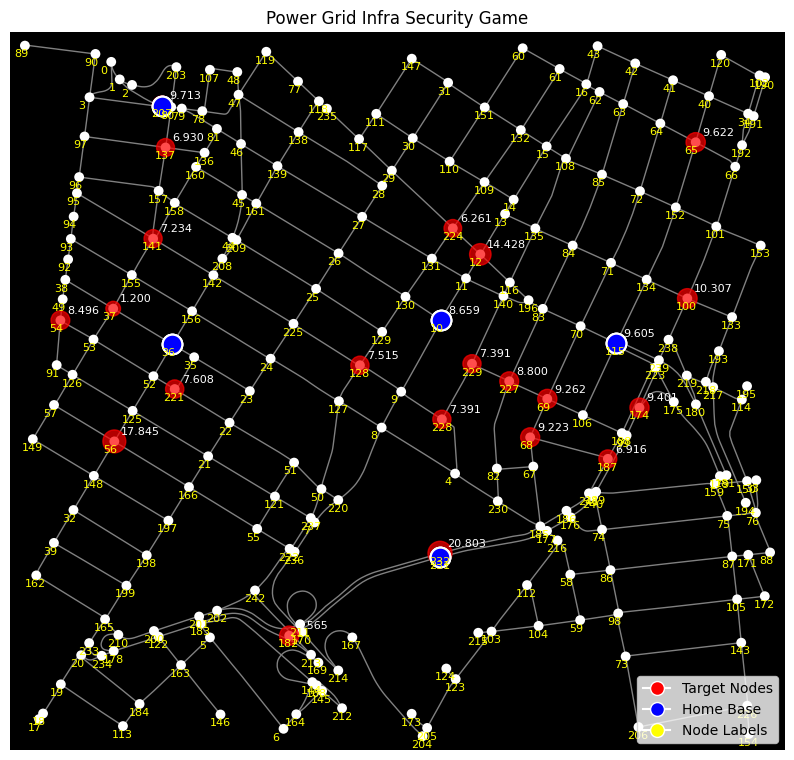

In [23]:
isg.draw_graph()

In [21]:
isg.graph.nodes[128]

{'y': 40.7161862,
 'x': -74.0025774,
 'street_count': 4,
 'target': True,
 'score': 7.5152282266858625,
 'escape_proximity': 162.2358502533246}

In [9]:
isg.schedule_form_dict["defender_actions"][51]

[{65}, {115, 174}]

In [11]:
isg.schedule_form_dict["targets"][22]

232

In [29]:
df = pd.DataFrame()
df["num_timesteps"] = num_timesteps_li
df["num_defenders"] = num_defenders_li
df["defense_time_threshold"] = dts
df["defender_utility"] = dus
df["support"] = supports
df["runtime"] = runtimes
df

,num_timesteps,num_defenders,defense_time_threshold,defender_utility,support,runtime
0,7,1,1,-0.645964,3,0.059053
1,7,1,2,-0.854907,2,0.023449
2,7,2,1,-0.475055,4,3.011664
3,7,2,2,-0.851645,2,0.420300
4,7,3,1,-0.420588,10,224.722065
5,7,3,2,-0.848407,2,11.527648
6,8,1,1,-0.645348,3,0.158633
7,8,1,2,-0.646582,3,0.048179
8,8,2,1,-0.474155,4,7.533163
9,8,2,2,-0.475958,4,2.296650


In [30]:
df.to_csv("ISG_NFG_SSE.csv")